# Importing  Necessary Libraries

In [2]:
import numpy as np #working with arrays and numerical calculations
import pandas as pd # load data
import matplotlib.pyplot as plt # plottting
import dask #scales data
import pyproj # photographic projections, such as lag/long into cartesian grid
import verde as vd #processing spatial data and gridding

# Want Figures Below to Be Larger

In [3]:
plt.rcParams["figure.dpi"] = 120 # make figures larger (more pixels) than default

## My Data

In [6]:
csv = pd.read_csv('DataBoxTest.csv')

# Recreate Scatterplot Using a Different Colormap

# Processing: Trends

In [38]:
#removal of 2D polynomial trends from the data

coordinates = (x,y)

#estimate polynomial coefficients for this trend
trend = vd.Trend(degree=1).fit(coordinates, csv.MagAnomaly)

#predict trend values and remove
trend_values = trend.predict(coordinates)
regional = csv.MagAnomaly - trend_values



# Blocked Reductions

In [39]:

reducer = vd.BlockReduce(np.median, spacing=1000)

block_coords, block_mag = reducer.filter(coordinates, csv.MagAnomaly)


# Weigh Uncertainty

In [40]:
#introduce uncertainty

uncertainty = csv['uncertainty']

weight = 1 / (uncertainty**2)

spacing = 300

reducer = vd.BlockMean(spacing, center_coordinates=True)
# First produce the weighted variance weights
variance_weights = reducer.filter(coordinates, csv.MagAnomaly, weight)[-1]
# And now produce the uncertainty propagation weights
reducer.set_params(uncertainty=True)
block_coords, block_mag, weight_uncertainty = reducer.filter(coordinates, csv.MagAnomaly, weight)

# Interpolation: Gridding with splines

In [268]:
#bi-harmonic spline model


In [41]:
#fit the model and predict

spline = vd.Spline()
spline.fit(block_coords, block_mag)
predicted = spline.predict(coordinates)

In [42]:
spline_residual = csv.MagAnomaly - predicted

scale = vd.maxabs(spline_residual)

<Figure size 432x288 with 0 Axes>

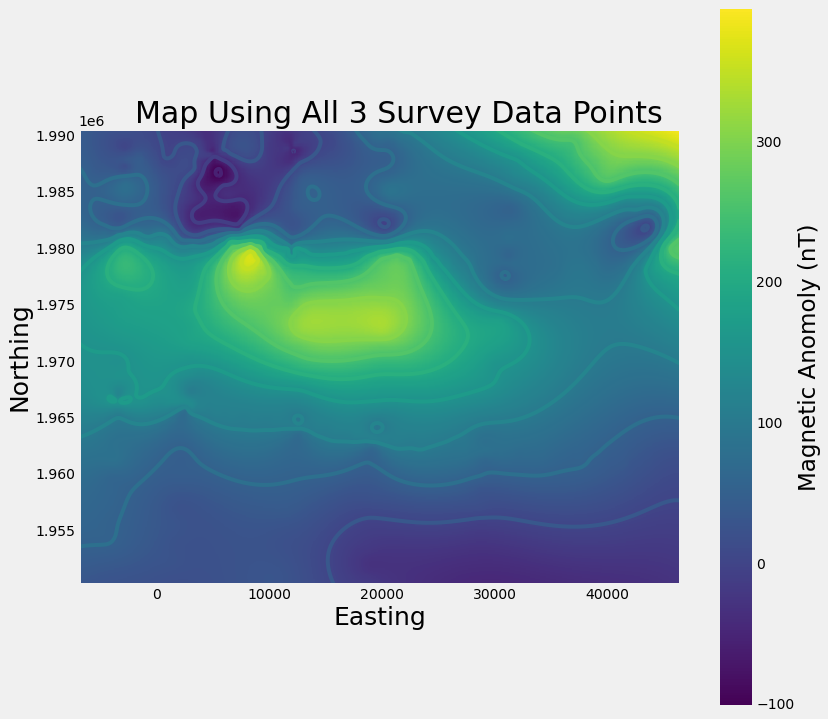

In [45]:
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(region, spacing=100)

grid_mag = spline.predict(grid_coords)

plt.figure()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,12))
plt.pcolormesh(grid_coords[0], grid_coords[1], grid_mag)
plt.axis("scaled")
plt.title('    Map Using All 3 Survey Data Points',fontsize = 30)
plt.xlabel('Easting', fontsize = 25)
plt.ylabel('Northing', fontsize = 25)
cbar = plt.colorbar()
cbar.set_label('Magnetic Anomoly (nT)', fontsize = 23)
plt.contour(grid_coords[0], grid_coords[1], grid_mag, levels=10)